In [2]:
import sys

# 엑세스키 유출을 막기 위해 비공유 폴더에서 불러옵니다!!!
sys.path.append("D:/GitHub/local_key")

In [3]:
from settings import RDS
import math
import numpy as np
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt

In [4]:
LMP = {
0 : "nose",
1 : "l_eye_i",
2 : "l_eye",
3 : "l_eye_o",
4 : "r_eye_i",
5 : "r_eye",
6 : "r_eye_o",
7 : "l_ear",
8 : "r_ear",
9 : "l_mouth",
10 : "r_mouth",
11 : "l_shldr",
12 : "r_shldr",
13 : "l_elbow",
14 : "r_elbow",
15 : "l_wrist",
16 : "r_wrist",
17 : "l_pinky",
18 : "r_pinky",
19 : "l_index",
20 : "r_index",
21 : "l_thumb",
22 : "r_thumb"
}

모듈화

In [5]:
def rds_heatmap_720(table_name : str, teacher : str, book_name : str, lecture_num : int, only_hand : bool = False, resolution : int = 3) :
    """
    Input
        1) table_name (str) :
            RDS에서 히트맵을 만들 테이블 이름
            
        2) teacher (str) :
            RDS에서 히트맵을 만들고 싶은 선생님의 이름
            
        3) book_name (str) :
            RDS에서 히트맵을 만들고 싶은 책의 이름
            
        4) lecture_num (int) :
            RDS에서 히트맵을 만들고 싶은 강의 번호
            
        5) only_hand (bool) :
            손을 포함한 상반신 전체와 오직 손만 선택
            
        6) resolution (int) :
            히트맵의 해상도 조절 1 / resolution
    Output
        1) heatmap :
            히트맵 그래프
        2) hand_list (dict) :
            양 팔의 어깨와 손목의 거리들의 분산과 표준 편차
    """
    if only_hand == True:
        points = list(range(15, 23))
        
    else :
        points = list(range(23))
    
    # MySQL에 연결
    connection = mysql.connector.connect(** RDS)
    cursor = connection.cursor()
    
    # 가져올 컬럼
    columns_list = [f"{LMP[part]}_{axis}" for part in points for axis in ["x", "y"]]
    columns_str = ', '.join(columns_list)

    # 테이블에서 데이터 조회
    cursor.execute(f"\
        SELECT {columns_str}\
        FROM {table_name}\
        WHERE 1 = 1\
            AND teacher = '{teacher}'\
            AND book_name = '{book_name}'\
            AND lecture_num = '{lecture_num}'\
        ;")
    data = cursor.fetchall()
    
    # 히트맵 크기 설정
    heatmap_size = (int(720 / resolution), int(1280 / resolution))

    # 그래프의 크기와 DPI 설정 (도화지 크기 설정)
    plt.subplots(figsize=(int(640), int(360)), dpi=4)

    # 히트맵 생성
    np_heatmap = np.zeros(heatmap_size)

    # 히트맵에 좌표 추가
    for frame_data in data:
        for i in range(0, len(frame_data), 2):
            x = int(frame_data[i] / resolution)
            y = int(frame_data[i + 1] / resolution)

            if 0 <= x < heatmap_size[1] and 0 <= y < heatmap_size[0]:
                np_heatmap[y, x] += 1  # 해당 좌표의 값을 1씩 증가시킴
    
    # 히트맵 그리기 ('viriresolution', 'plasma', 'inferno', 'magma')
    heatmap = sns.heatmap(np_heatmap, cmap = 'plasma')
    
    # 연결 닫기
    cursor.close()
    connection.close()
    
    if points == list(range(15, 23)) :
        # 양쪽 어께와 손목의 거리 리스트
        l_resolutiontances = []
        r_resolutiontances = []
        for i in range(len(data)) :
            l_x_1, l_y_1 = data[i][0], data[i][1]
            r_x_1, r_y_1 = data[i][2], data[i][3]
            l_x_2, l_y_2 = data[i][4], data[i][5]
            r_x_2, r_y_2 = data[i][6], data[i][7]

            l_resolutiontances.append(math.sqrt((l_x_1 - l_x_2) ** 2 + (l_y_1 - l_y_2) ** 2))
            r_resolutiontances.append(math.sqrt((r_x_1 - r_x_2) ** 2 + (r_y_1 - r_y_2) ** 2))

        # 거리들의 분산을 계산
        l_var = calculate_variance(l_resolutiontances)
        r_var = calculate_variance(r_resolutiontances)

        # 거리들의 표준편차를 계산
        l_SD = calculate_standard_deviation(l_var)
        r_SD = calculate_standard_deviation(r_var)

        hand_list = [{
            "l_variance" : l_var,
            "r_variance" : r_var,
            "l_standard_deviation" : l_SD,
            "r_standard_deviation" : r_SD
            }]
        
        return heatmap, hand_list
    
    return heatmap


def calculate_variance(distances : list) -> float :
    """
    Input
        1) distances (list) :
            분산을 구할 숫자들의 배열
    Output
        1) variance (float) :
            입력받은 숫자 배열들의 분산 값
    """
    mean = sum(distances) / len(distances)
    variance = sum((distance - mean) ** 2 for distance in distances) / len(distances)
    
    return variance


def calculate_standard_deviation(variance : int or float) -> float :
    """
    Input
        1) variance (int, float) :
            분산 값 (제곱근할 값)
    Output
        1) standard_deviation (float) :
            입력받은 값의 표준편차 (제곱근)
    """
    standard_deviation = variance ** 0.5
    
    return standard_deviation

(<Axes: >,
 [{'l_variance': 185.53294667070628,
   'r_variance': 118.28566908659806,
   'l_standard_deviation': 13.621047928507787,
   'r_standard_deviation': 10.875921528155583}])

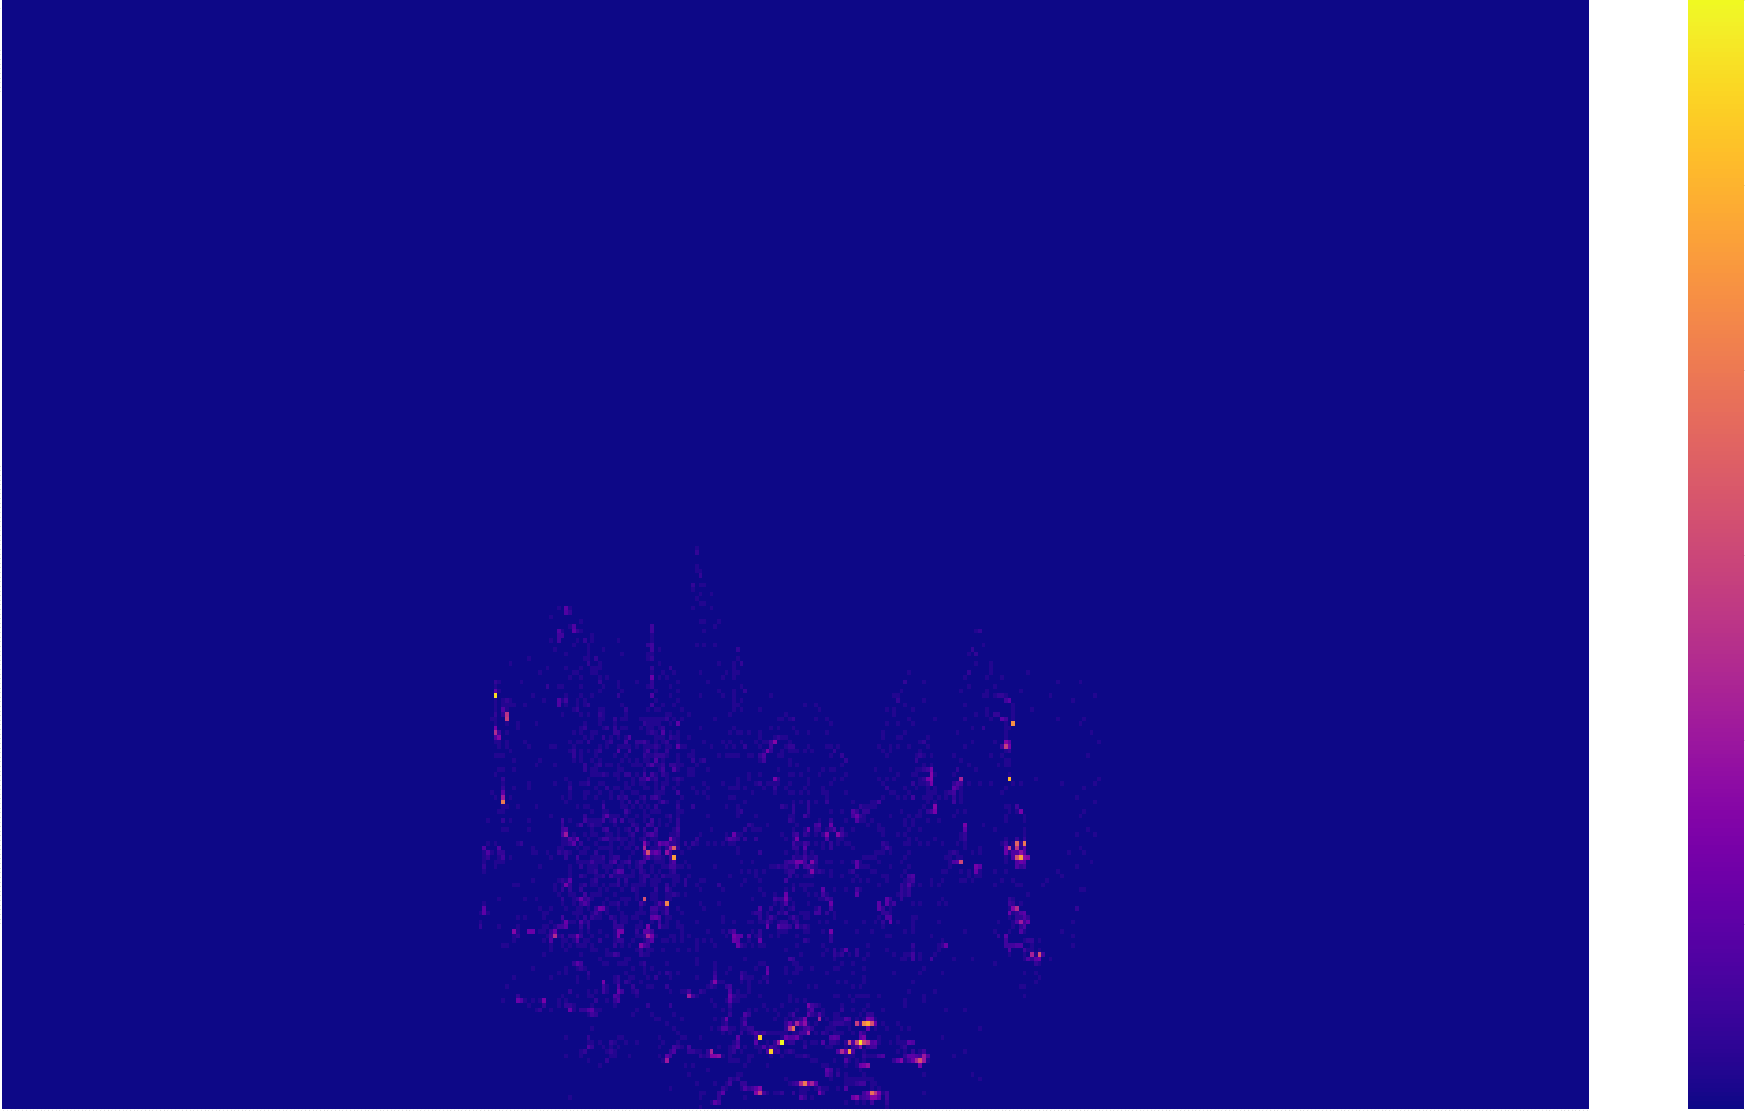

In [6]:
# 조회할 테이블 이름
table_name = "VIDEO_FEATURE_LMP_test"
teacher = "손석민"
book_name = "EBS중학뉴런수학2(상)"
lecture_num = 1
only_hand = True

rds_heatmap_720(table_name, teacher, book_name, lecture_num, only_hand)

외부 모듈로 불러오기

In [ ]:
import heatmap

# 조회할 테이블 이름
table_name = "VIDEO_FEATURE_LMP_test"
teacher = "손석민"
book_name = "EBS중학뉴런수학2(상)"
lecture_num = 1
only_hand = True

heatmap.rds_heatmap_720(table_name, teacher, book_name, lecture_num, only_hand)

RDS 데이터로 히트맵 만들기 - 상체

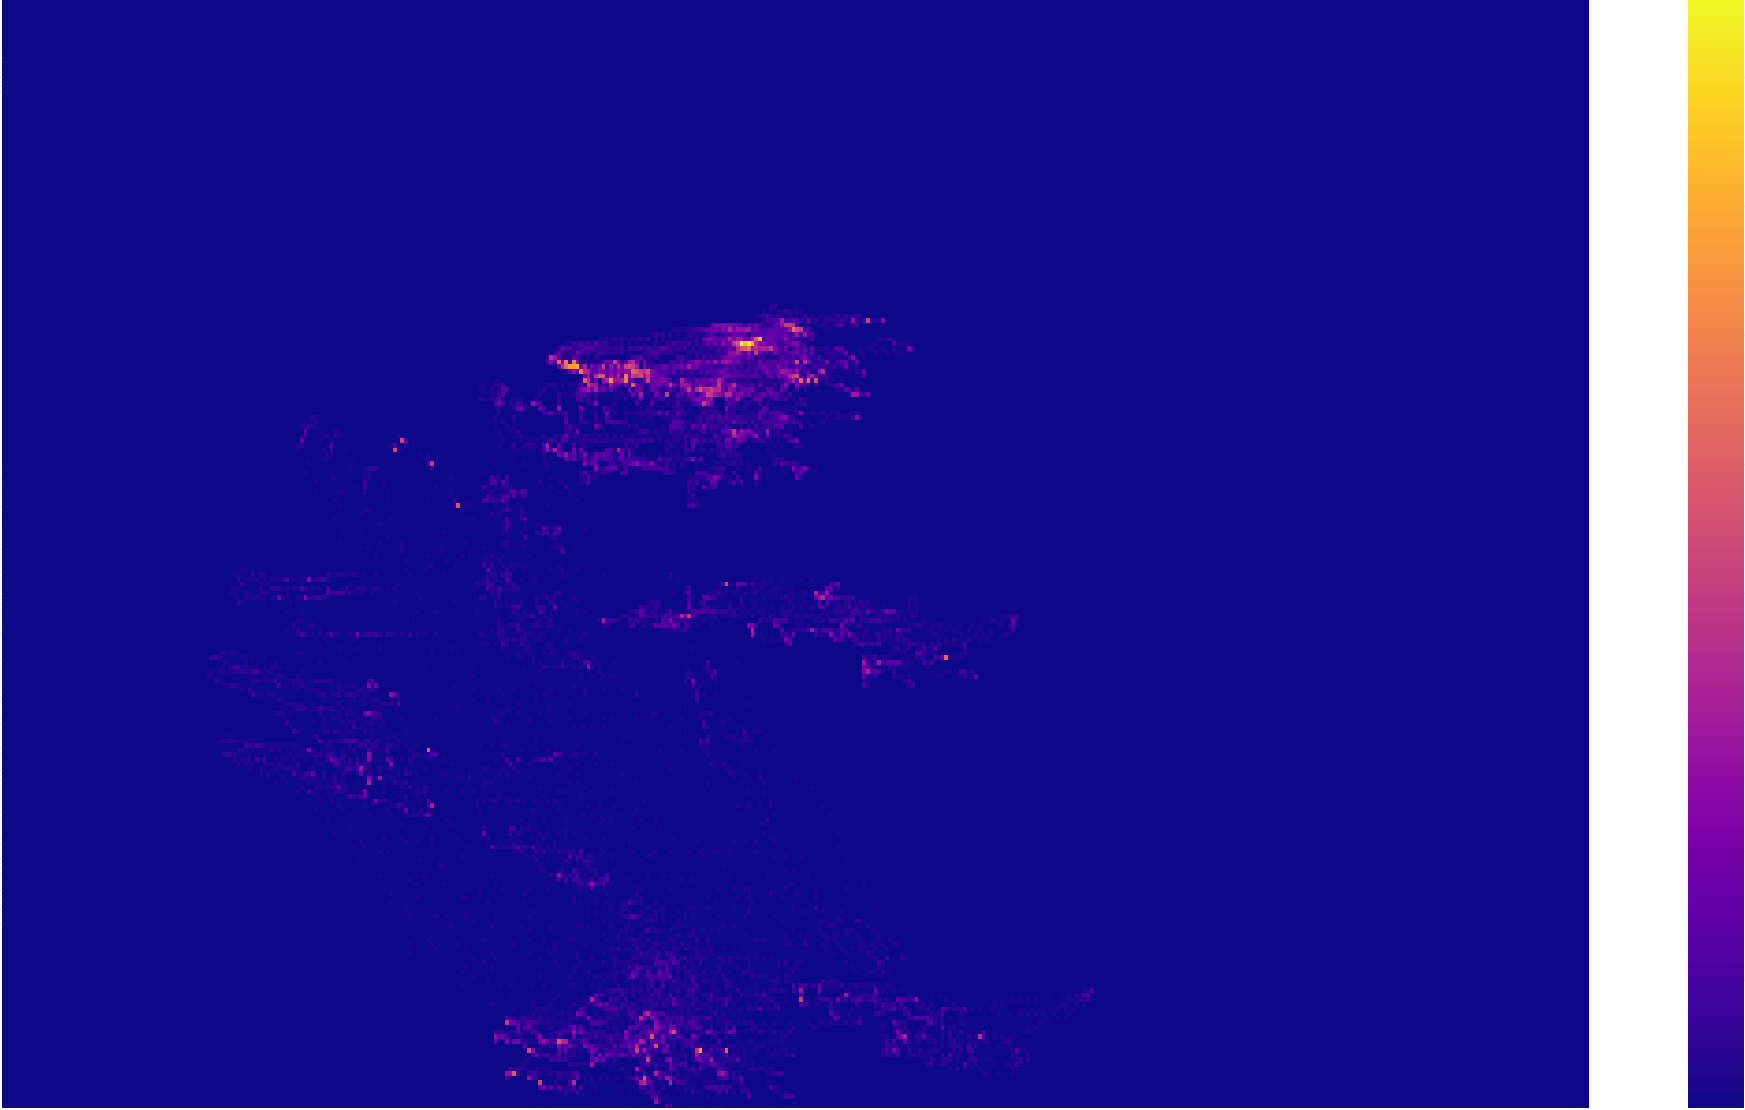

In [72]:
# MySQL에 연결
connection = mysql.connector.connect(** RDS)
cursor = connection.cursor()

# 조회할 테이블 이름
table_name = "VIDEO_FEATURE_LMP_test"
teacher = "손석민"
book_name = "EBS중학뉴런수학2(상)"
lecture_num = 1
points = list(range(23))

columns_list = [f"{LMP[part]}_{axis}" for part in points for axis in ["x", "y"]]
columns_str = ', '.join(columns_list)

# 테이블에서 데이터 조회
cursor.execute(f"\
    SELECT {columns_str}\
    FROM {table_name}\
    WHERE 1 = 1\
        AND teacher = '{teacher}'\
        AND book_name = '{book_name}'\
        AND lecture_num = '{lecture_num}'\
    ;")
data = cursor.fetchall()

# 히트맵 해상도 크기 조절 1 / resolution
resolution = 3

# 히트맵 크기 설정
heatmap_size = (int(720 / resolution), int(1280 / resolution))

# 그래프의 크기와 DPI 설정
plt.subplots(figsize=(int(640), int(360)), dpi=4)

# 히트맵 생성
np_heatmap = np.zeros(heatmap_size)

# 히트맵에 좌표 추가
for frame_data in data:
    for i in range(0, len(frame_data), 2):
        x = int(frame_data[i] / resolution)
        y = int(frame_data[i + 1] / resolution)

        if 0 <= x < heatmap_size[1] and 0 <= y < heatmap_size[0]:
            np_heatmap[y, x] += 1  # 해당 좌표의 값을 1씩 증가시킴

# 히트맵 그리기 ('viriresolution', 'plasma', 'inferno', 'magma')
sns.heatmap(np_heatmap, cmap = 'plasma')

# 연결 닫기
cursor.close()
connection.close()

RDS 데이터로 히트맵 만들기 - 손

In [83]:
def calculate_variance(distances : list) -> float :
    """
    Input
        1) distances (list) :
            분산을 구할 숫자들의 배열
    Output
        1) variance (float) :
            입력받은 숫자 배열들의 분산 값
    """
    mean = sum(distances) / len(distances)
    variance = sum((distance - mean) ** 2 for distance in distances) / len(distances)
    
    return variance

In [84]:
def calculate_standard_deviation(variance : int or float) -> float :
    """
    Input
        1) variance (int, float) :
            분산 값 (제곱근할 값)
    Output
        1) standard_deviation (float) :
            입력받은 값의 표준편차 (제곱근)
    """
    standard_deviation = variance ** 0.5
    
    return standard_deviation

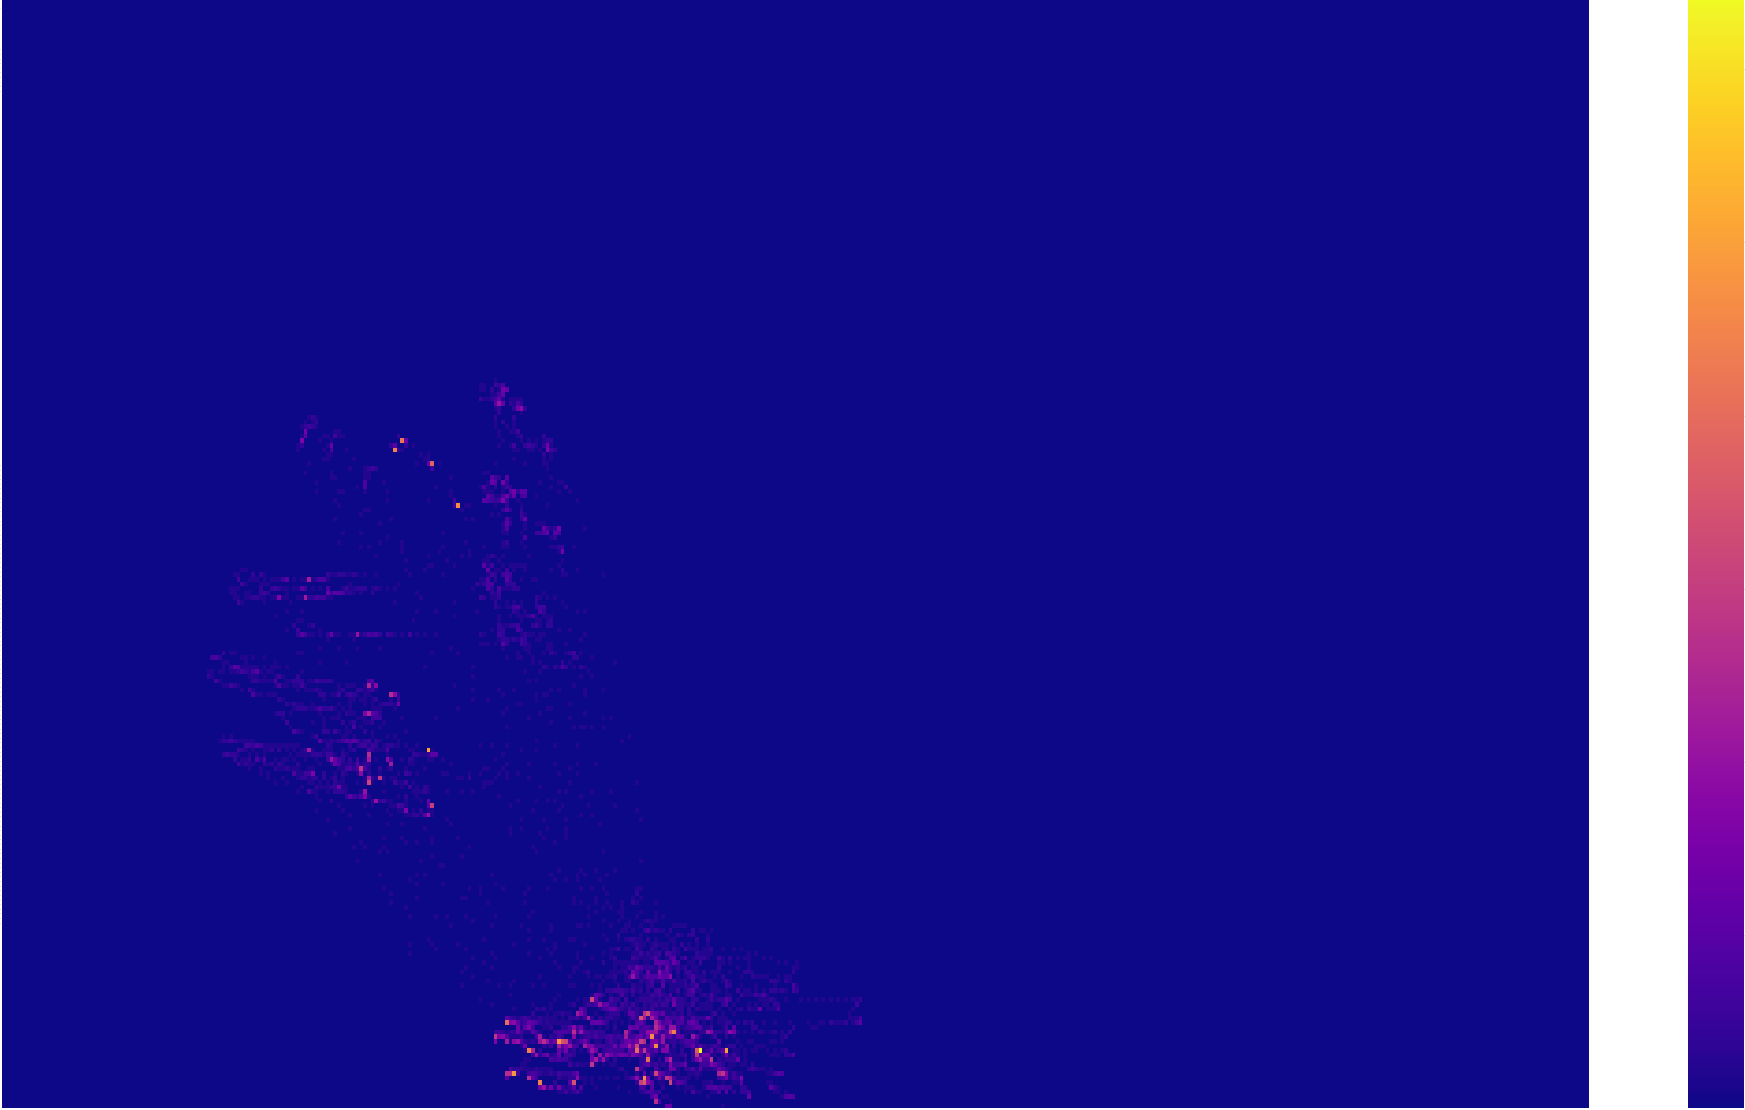

In [87]:
# MySQL에 연결
connection = mysql.connector.connect(** RDS)
cursor = connection.cursor()

# 조회할 테이블 이름
table_name = "VIDEO_FEATURE_LMP_test"
teacher = "손석민"
book_name = "EBS중학뉴런수학2(상)"
lecture_num = 1
points = list(range(15, 23))

columns_list = [f"{LMP[part]}_{axis}" for part in points for axis in ["x", "y"]]
columns_str = ', '.join(columns_list)

# 테이블에서 데이터 조회
cursor.execute(f"\
    SELECT {columns_str}\
    FROM {table_name}\
    WHERE 1 = 1\
        AND teacher = '{teacher}'\
        AND book_name = '{book_name}'\
        AND lecture_num = '{lecture_num}'\
    ;")
data = cursor.fetchall()

# 양쪽 어께와 손목의 거리 리스트
l_resolutiontances = []
r_resolutiontances = []
for i in range(len(data)) :
    l_x_1, l_y_1 = data[i][0], data[i][1]
    r_x_1, r_y_1 = data[i][2], data[i][3]
    l_x_2, l_y_2 = data[i][4], data[i][5]
    r_x_2, r_y_2 = data[i][6], data[i][7]

    l_resolutiontances.append(math.sqrt((l_x_1 - l_x_2) ** 2 + (l_y_1 - l_y_2) ** 2))
    r_resolutiontances.append(math.sqrt((r_x_1 - r_x_2) ** 2 + (r_y_1 - r_y_2) ** 2))

# 거리들의 분산을 계산
l_var = calculate_variance(l_resolutiontances)
r_var = calculate_variance(r_resolutiontances)

# 거리들의 표준편차를 계산
l_SD = calculate_standard_deviation(l_var)
r_SD = calculate_standard_deviation(r_var)

hand_list = [{
    "l_variance" : l_var,
    "r_variance" : r_var,
    "l_standard_deviation" : l_SD,
    "r_standard_deviation" : r_SD
    }]

# 히트맵 해상도 크기 조절 1 / resolution
resolution = 3

# 히트맵 크기 설정
heatmap_size = (int(720 / resolution), int(1280 / resolution))

# 그래프의 크기와 DPI 설정
plt.subplots(figsize=(int(640), int(360)), dpi=4)

# 히트맵 생성
np_heatmap = np.zeros(heatmap_size)

# 히트맵에 좌표 추가
for frame_data in data:
    for i in range(0, len(frame_data), 2):
        x = int(frame_data[i] / resolution)
        y = int(frame_data[i + 1] / resolution)

        if 0 <= x < heatmap_size[1] and 0 <= y < heatmap_size[0]:
            np_heatmap[y, x] += 1  # 해당 좌표의 값을 1씩 증가시킴

# 히트맵 그리기 ('viriresolution', 'plasma', 'inferno', 'magma')
sns.heatmap(np_heatmap, cmap = 'plasma')

# 연결 닫기
cursor.close()
connection.close()

모듈화 확인

In [2]:
import heatmap

# 조회할 테이블 이름
table_name = "VIDEO_FEATURE_LMP_test"
teacher = "손석민"
book_name = "EBS중학뉴런수학2(상)"
lecture_num = 1
only_hand = True

heatmap.rds_heatmap_720(table_name, teacher, book_name, lecture_num, only_hand)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [{'l_variance': 21.166541986094355,
   'r_variance': 64.32400073944869,
   'l_standard_deviation': 4.60071103049239,
   'r_standard_deviation': 8.020224481861383}])